# AI for Google Chrome Dino Game

### Description: 
This is a simple AI program for the Chrome Dino game. The program will capture the screen image in real time and determine what instructions should be input to the game. The purpose of the program is to allow the dinosaur to pass more obstacles (that is, to survive longer). Next, I will gradually achieve this goal.

##### Step1. Import Dependencies
Import all needed dependencies

In [1]:
import os 
import cv2
import time
import pydirectinput
import pytesseract
import numpy as np
from mss import mss
from matplotlib import pyplot as plt
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from stable_baselines3 import DQN
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback 
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'D:\Tesseract-OCR\tesseract.exe'

In [3]:
print(np.__version__)

1.24.2


##### Step2. Define the functions you need to use when learning

2.1 define

In [4]:
class WebGame(Env):
    def __init__(self):
        super().__init__()
        self.observation_space = Box(low=0, high=255,shape=(1,83,100),dtype=np.uint8)
        self.action_space = Discrete(3)

        self.cap = mss()
        self.game_location = {'top': 375, 'left': 900, 'width': 250, 'height': 250}
        self.done_location = {'top': 440, 'left': 1120, 'width': 300, 'height': 35}

    def step(self, action):
        action_map = {
          0: 'space',
          1: 'down',
          2: 'no_op'
        }
    
        if action != 2:
            pydirectinput.press(action_map[action])

        done, done_cap = self.get_done()
        observation = self.get_observation()
        reward = 1
    
        terminated = done 
        truncated = False

        info = {}
        return observation, reward, terminated, truncated, info
    
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
        
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        observation = self.get_observation()
        return observation, {}

    def close(self):
        cv2.destroyAllWindows()
        
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100))
        return channel

        
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        done_strings = ['GAME']
        done = False
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True
        return done, done_cap

2.2 test

In [5]:
env = WebGame()

In [6]:
obs=env.get_observation()

Check if the observation space includes both the dinosaur and the obstacles ahead.

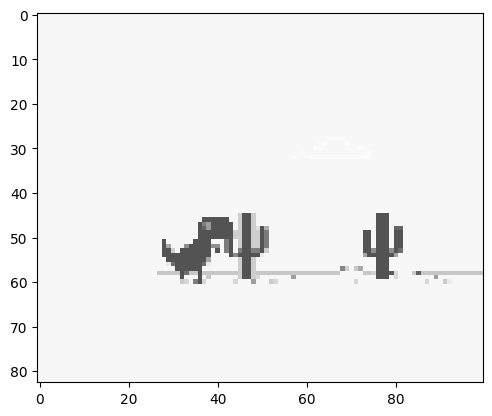

In [7]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

Check if the GAME-OVER space can detect the "GAME" text.

In [8]:
done, done_cap = env.get_done()

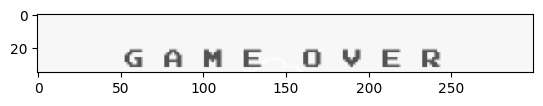

In [9]:
plt.imshow(done_cap)

In [10]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [11]:
done

True

Check if the program can loop correctly, as this will help the program train itself effectively.

In [12]:
for episode in range(3): 
    obs = env.reset()
    done = False  
    total_reward   = 0
    while not done: 
        obs, reward,  done, rrr, info =  env.step(env.action_space.sample())
        total_reward  += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    

Total Reward for episode 0 is 16
Total Reward for episode 1 is 15
Total Reward for episode 2 is 15


In [13]:
env_checker.check_env(env)

##### Step3. Train our model

3.1 Define callback function

In [14]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [15]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [16]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

3.2 Use the DQN model from stable_baselines3 for training.

In [17]:
env = WebGame()

In [18]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, 
            buffer_size=300000, learning_starts=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Here, totalsteps is a tunable hyperparameter. If the training performance is unsatisfactory, please increase totalsteps, but be aware that this will also increase the training time.

Here, 1000 is just a test number used before submitting to GitHub to check if the program can train itself successfully. To achieve successful training results, please set a larger totalsteps, such as 5000000.

In [19]:
model.learn(total_timesteps=1000, callback=callback)

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.8     |
|    ep_rew_mean      | 13.8     |
|    exploration_rate | 0.477    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 2        |
|    time_elapsed     | 27       |
|    total_timesteps  | 55       |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0677   |
|    n_updates        | 13       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 12.8     |
|    ep_rew_mean      | 12.8     |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 52       |
|    total_timesteps  | 102      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.00498

##### Step4. Test our model

Now that we've successfully trained our model, we can test the training results of the model.

In [47]:
for episode in range(1): 
    obs, _ = env.reset()
    done = False  
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, rrr, info = env.step(int(action))
        time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))    
    time.sleep(2)

Total Reward for episode 0 is 18


P.S. I didn't use Google's official Dinosaur Game webpage. Instead, I used the page provided by https://trex-runner.com/ and zoomed out the webpage to 67%. Otherwise, game_location and done_location may not obtain the correct information.